### Explaining and Harnessing Adversarial Examples 
> by Goodfellow et al. 

Here we create an adversarial example using the Fast Gradient Signed Method (FGSM) attack as described in the aforementioned paper 

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a white box attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. One of the most famous examples of an adversarial image shown below is taken from the aforementioned paper.

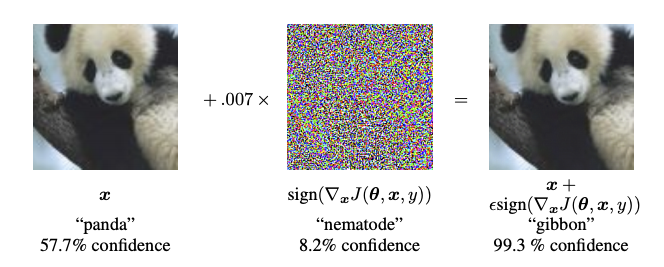

In [1]:
from IPython.display import Image
Image("adversarial_example.png")

Here, starting with the image of a panda, the attacker adds small perturbations (distortions) to the original image, which results in the model labelling this image as a gibbon, with high confidence. 

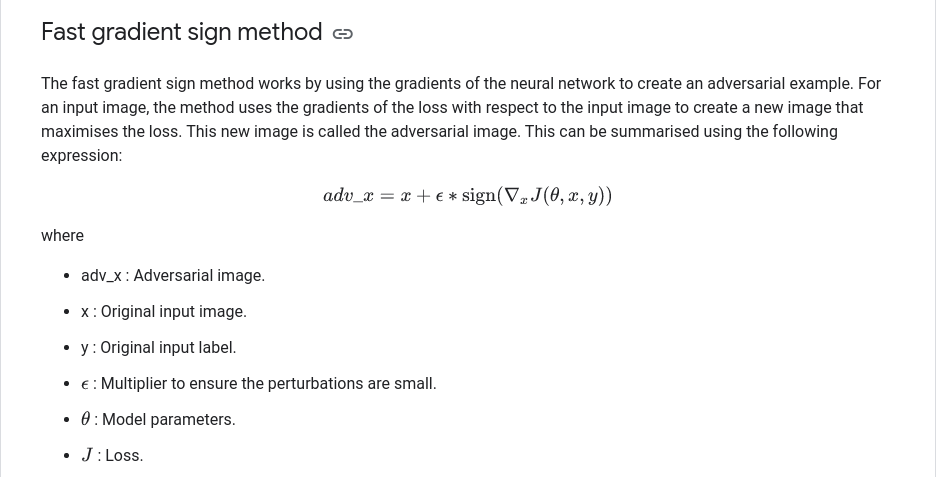

In [2]:
Image("FGSM.png")

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.